# K-face Finetuning (.ipynb)

Import modules

In [1]:
import torch
torch.cuda.empty_cache()
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

In [2]:
# Import Moudles and Packages
import gc
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import time
import random

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["axes.grid"]=False

# Import pytorch modules
import torch
import torch.nn as nn
from torch.utils import data as D

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.cuda.amp import autocast, GradScaler
from madgrad import MADGRAD

import natsort

print("| Pytorch version: {}".format(torch.__version__))
print("| GPU: {}".format(torch.cuda.is_available()))
print("| Device : ",device)
print("| Device name: ", torch.cuda.get_device_name(0))
print("| Device count: ", torch.cuda.device_count())

| Pytorch version: 1.10.0+cu102
| GPU: True
| Device :  cuda:1
| Device name:  Tesla T4
| Device count:  4


In [3]:
# Import local modules
from src import config as C
from src.models import resnet, xception

from src.utils.collate_fn import *
from src.utils.print_overwrite import *
from src.utils.seed import *
from src.utils.view_kypoints import *

from src.dataset.kface_dataset import *
from src.dataset.kface_transform_A import *

seed_everything(C.SEED)

print(f"| Number of image : {len(C.IMAGE_LIST)}")
print(f"| Number of label : {len(C.LABEL_LIST)}")
print(f"| Number of trainset : {C.LEN_TRAIN_SET}")
print(f"| Number of validset : {C.LEN_VALID_SET}")

| Number of image : 100
| Number of label : 100
| Number of trainset : 90
| Number of validset : 10


In [4]:
class DepthewiseSeperableConv2d(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, **kwargs):
        super(DepthewiseSeperableConv2d, self).__init__()

        self.depthwise = nn.Conv2d(input_channels, input_channels, kernel_size, groups = input_channels, bias = False, **kwargs)
        self.pointwise = nn.Conv2d(input_channels, output_channels, 1, bias = False)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)

        return x

In [5]:
class EntryBlock(nn.Module):
    def __init__(self):
        super(EntryBlock, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding = 1, bias = False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding = 1, bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )

        self.conv3_residual = nn.Sequential(
            DepthewiseSeperableConv2d(64, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(64, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(3, stride = 2, padding = 1),
        )

        self.conv3_direct = nn.Sequential(
            nn.Conv2d(64, 128, 1, stride = 2),
            nn.BatchNorm2d(128),
        )

        self.conv4_residual = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(128, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(128, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(3, stride = 2, padding = 1)
        )

        self.conv4_direct = nn.Sequential(
            nn.Conv2d(128, 256, 1, stride = 2),
            nn.BatchNorm2d(256),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        residual = self.conv3_residual(x)
        direct = self.conv3_direct(x)
        x = residual + direct
        
        residual = self.conv4_residual(x)
        direct = self.conv4_direct(x)
        x = residual + direct

        return x

In [6]:
class MiddleBasicBlock(nn.Module):
    def __init__(self):
        super(MiddleBasicBlock, self).__init__()

        self.conv1 = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256)
        )
        self.conv2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256)
        )
        self.conv3 = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256)
        )

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.conv2(residual)
        residual = self.conv3(residual)

        return x + residual


class MiddleBlock(nn.Module):
    def __init__(self, num_blocks):
        super().__init__()

        self.block = nn.Sequential(*[MiddleBasicBlock() for _ in range(num_blocks)])

    def forward(self, x):
        x = self.block(x)

        return x

In [7]:
class ExitBlock(nn.Module):
    def __init__(self):
        super(ExitBlock, self).__init__()

        self.residual = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(3, stride = 2, padding = 1)
        )

        self.direct = nn.Sequential(
            nn.Conv2d(256, 512, 1, stride = 2),
            nn.BatchNorm2d(512)
        )

        self.conv = nn.Sequential(
            DepthewiseSeperableConv2d(512, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(512, 1024, 3, padding = 1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2)
        )

        self.dropout = nn.Dropout(0.3)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        direct = self.direct(x)
        residual = self.residual(x)
        x = direct + residual
        
        x = self.conv(x)
        x = self.avgpool(x)
        x = self.dropout(x)

        return x

# __Initializing the Xception Net model__

In [8]:
class XceptionNet(nn.Module):
    def __init__(self, num_class, num_middle_blocks = 6):
        super(XceptionNet, self).__init__()
        self.num_class = num_class
        self.entry_block = EntryBlock()
        self.middel_block = MiddleBlock(num_middle_blocks)
        self.exit_block = ExitBlock()

        self.fc = nn.Linear(1024, num_class)

    def forward(self, x):
        x = self.entry_block(x)
        x = self.middel_block(x)
        x = self.exit_block(x)

        x = x.view(x.size(0), -1)
        
        x = self.fc(x)

        return x

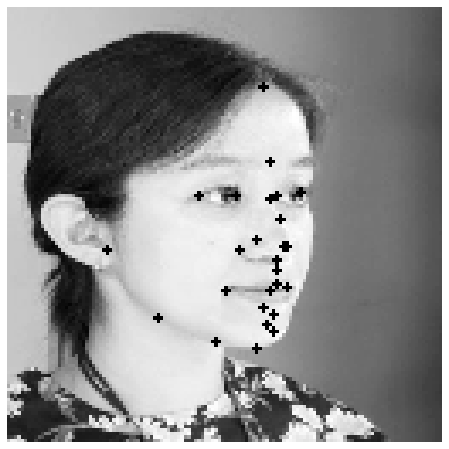

In [9]:
k_dataset_train = kfacedataset(
    image_list=C.IMAGE_LIST,
    label_list=C.LABEL_LIST,
    type="train",
    transform=get_augmentation(data_type="train")
    )

k_dataset_valid = kfacedataset(
    image_list=C.IMAGE_LIST,
    label_list=C.LABEL_LIST,
    type="valid",
    transform=get_augmentation(data_type="valid")
    )

# # (Option) visualize dataset
for idx, (image, landmarks) in enumerate(k_dataset_train): # torch.Size([1, 512, 512])
    if idx == 1:
        vis_keypoints(image, landmarks)

In [10]:
train_dataset, _ = D.random_split(k_dataset_train, [C.LEN_TRAIN_SET, C.LEN_VALID_SET])
_, valid_dataset = D.random_split(k_dataset_valid, [C.LEN_TRAIN_SET, C.LEN_VALID_SET])

train_loader = D.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
valid_loader = D.DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=0)

train_images, train_landmarks = next(iter(train_loader))
valid_images, valid_landmarks = next(iter(valid_loader))

print(f"| Size of image in train_loader : {train_images.shape}")
print(f"| Size of label in train_loader : {train_landmarks.shape}")
print(f"| Size of image in train_loader : {valid_images.shape}")
print(f"| Size of label in train_loader : {valid_landmarks.shape}")

| Size of image in train_loader : torch.Size([32, 1, 128, 128])
| Size of label in train_loader : torch.Size([32, 27, 2])
| Size of image in train_loader : torch.Size([8, 1, 128, 128])
| Size of label in train_loader : torch.Size([8, 27, 2])


In [11]:
pretrained_model = '/home/ubuntu/workspace/FLD-scratch/src/pretrained_model/xcep_27pt_50epoch.pt'
model = XceptionNet(num_class=54)
model.eval()

if pretrained_model:
    state_dict = torch.load(pretrained_model,map_location='cpu')
    model.load_state_dict(state_dict)

model = model.to(device)

In [12]:
x = torch.randn([1, 1, 128, 128]).to(device)
out = model(x).to(device)
print(f"input : {x.shape} | output : {out.size()}")

input : torch.Size([1, 1, 128, 128]) | output : torch.Size([1, 54])


set loss and optimizer

In [13]:
criterion = nn.MSELoss()
optimizer = MADGRAD(params=model.parameters(), lr=C.LEARNING_RATE, weight_decay=C.WEIGHT_DECAY)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=C.EPOCHS, T_mult=1)

In [14]:
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

loss_min = np.inf

start_time = time.time()
for epoch in range(100):
    
    model.train()
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    scaler = GradScaler()    
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (images, landmarks) in pbar:

        landmarks = landmarks.view(landmarks.size(0),-1)
        
        images = images.to(device)
        landmarks = landmarks.to(device)
        
        with autocast(enabled=True):
            model = model.to(device)
            
            predictions = model(images)
            loss_train_step = criterion(predictions, landmarks)
        
        scaler.scale(loss_train_step).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
                
        loss_train += loss_train_step
        running_loss = loss_train/(step+1)
        
        description = f"| # Train-Epoch : {epoch + 1} Loss : {(running_loss):.4f}"
        pbar.set_description(description)
    
    model.eval()  
    with torch.no_grad():
        
        pbar_valid = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for step, (images, landmarks) in pbar_valid:
                  
            images = images.to(device)
            landmarks = landmarks.view(landmarks.size(0),-1).to(device)
        
            predictions = model(images).to(device)
                    
            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step
            running_loss = loss_valid/(step+1)

            description = f"| # Valid-Epoch : {epoch + 1} Loss : {(running_loss):.4f}"
            pbar_valid.set_description(description)
            
            
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)

    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(model.state_dict(), '/home/ubuntu/workspace/FLD-scratch/src/pretrained_model/xcep_27pt_50epoch.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, C.EPOCHS))
        print('Model Saved\n')

print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

| # Train-Epoch : 1 Loss : 0.0834: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]
| # Valid-Epoch : 1 Loss : 0.0400: 100%|██████████| 2/2 [00:00<00:00, 14.75it/s]



Minimum Validation Loss of 0.0400 at epoch 0/200
Model Saved



| # Train-Epoch : 2 Loss : 0.0699: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]
| # Valid-Epoch : 2 Loss : 0.0411: 100%|██████████| 2/2 [00:00<00:00, 13.19it/s]
| # Train-Epoch : 3 Loss : 0.0711: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]
| # Valid-Epoch : 3 Loss : 0.0408: 100%|██████████| 2/2 [00:00<00:00, 14.55it/s]
| # Train-Epoch : 4 Loss : 0.0704: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]
| # Valid-Epoch : 4 Loss : 0.0383: 100%|██████████| 2/2 [00:00<00:00, 15.33it/s]



Minimum Validation Loss of 0.0383 at epoch 3/200
Model Saved



| # Train-Epoch : 5 Loss : 0.0578: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]
| # Valid-Epoch : 5 Loss : 0.0343: 100%|██████████| 2/2 [00:00<00:00, 13.70it/s]



Minimum Validation Loss of 0.0343 at epoch 4/200
Model Saved



| # Train-Epoch : 6 Loss : 0.0480: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]
| # Valid-Epoch : 6 Loss : 0.0301: 100%|██████████| 2/2 [00:00<00:00, 14.89it/s]



Minimum Validation Loss of 0.0301 at epoch 5/200
Model Saved



| # Train-Epoch : 7 Loss : 0.0443: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]
| # Valid-Epoch : 7 Loss : 0.0259: 100%|██████████| 2/2 [00:00<00:00, 13.42it/s]



Minimum Validation Loss of 0.0259 at epoch 6/200
Model Saved



| # Train-Epoch : 8 Loss : 0.0387: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]
| # Valid-Epoch : 8 Loss : 0.0219: 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]



Minimum Validation Loss of 0.0219 at epoch 7/200
Model Saved



| # Train-Epoch : 9 Loss : 0.0334: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]
| # Valid-Epoch : 9 Loss : 0.0181: 100%|██████████| 2/2 [00:00<00:00, 14.21it/s]



Minimum Validation Loss of 0.0181 at epoch 8/200
Model Saved



| # Train-Epoch : 10 Loss : 0.0288: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]
| # Valid-Epoch : 10 Loss : 0.0143: 100%|██████████| 2/2 [00:00<00:00, 14.76it/s]



Minimum Validation Loss of 0.0143 at epoch 9/200
Model Saved



| # Train-Epoch : 11 Loss : 0.0255: 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]
| # Valid-Epoch : 11 Loss : 0.0112: 100%|██████████| 2/2 [00:00<00:00, 10.75it/s]



Minimum Validation Loss of 0.0112 at epoch 10/200
Model Saved



| # Train-Epoch : 12 Loss : 0.0205: 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]
| # Valid-Epoch : 12 Loss : 0.0085: 100%|██████████| 2/2 [00:00<00:00, 15.03it/s]



Minimum Validation Loss of 0.0085 at epoch 11/200
Model Saved



| # Train-Epoch : 13 Loss : 0.0157: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]
| # Valid-Epoch : 13 Loss : 0.0061: 100%|██████████| 2/2 [00:00<00:00, 14.63it/s]



Minimum Validation Loss of 0.0061 at epoch 12/200
Model Saved



| # Train-Epoch : 14 Loss : 0.0127: 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]
| # Valid-Epoch : 14 Loss : 0.0045: 100%|██████████| 2/2 [00:00<00:00, 11.39it/s]



Minimum Validation Loss of 0.0045 at epoch 13/200
Model Saved



| # Train-Epoch : 15 Loss : 0.0092: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]
| # Valid-Epoch : 15 Loss : 0.0034: 100%|██████████| 2/2 [00:00<00:00, 12.00it/s]



Minimum Validation Loss of 0.0034 at epoch 14/200
Model Saved



| # Train-Epoch : 16 Loss : 0.0066: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]
| # Valid-Epoch : 16 Loss : 0.0028: 100%|██████████| 2/2 [00:00<00:00, 15.10it/s]



Minimum Validation Loss of 0.0028 at epoch 15/200
Model Saved



| # Train-Epoch : 17 Loss : 0.0057: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]
| # Valid-Epoch : 17 Loss : 0.0023: 100%|██████████| 2/2 [00:00<00:00, 15.05it/s]



Minimum Validation Loss of 0.0023 at epoch 16/200
Model Saved



| # Train-Epoch : 18 Loss : 0.0074: 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]
| # Valid-Epoch : 18 Loss : 0.0022: 100%|██████████| 2/2 [00:00<00:00, 14.81it/s]



Minimum Validation Loss of 0.0022 at epoch 17/200
Model Saved



| # Train-Epoch : 19 Loss : 0.0028: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]
| # Valid-Epoch : 19 Loss : 0.0020: 100%|██████████| 2/2 [00:00<00:00, 14.44it/s]



Minimum Validation Loss of 0.0020 at epoch 18/200
Model Saved



| # Train-Epoch : 20 Loss : 0.0025: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]
| # Valid-Epoch : 20 Loss : 0.0019: 100%|██████████| 2/2 [00:00<00:00, 14.75it/s]



Minimum Validation Loss of 0.0019 at epoch 19/200
Model Saved



| # Train-Epoch : 21 Loss : 0.0027: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]
| # Valid-Epoch : 21 Loss : 0.0017: 100%|██████████| 2/2 [00:00<00:00, 14.81it/s]



Minimum Validation Loss of 0.0017 at epoch 20/200
Model Saved



| # Train-Epoch : 22 Loss : 0.0023: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]
| # Valid-Epoch : 22 Loss : 0.0015: 100%|██████████| 2/2 [00:00<00:00, 13.57it/s]



Minimum Validation Loss of 0.0015 at epoch 21/200
Model Saved



| # Train-Epoch : 23 Loss : 0.0021: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]
| # Valid-Epoch : 23 Loss : 0.0014: 100%|██████████| 2/2 [00:00<00:00, 15.29it/s]



Minimum Validation Loss of 0.0014 at epoch 22/200
Model Saved



| # Train-Epoch : 24 Loss : 0.0023: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]
| # Valid-Epoch : 24 Loss : 0.0012: 100%|██████████| 2/2 [00:00<00:00, 13.23it/s]



Minimum Validation Loss of 0.0012 at epoch 23/200
Model Saved



| # Train-Epoch : 25 Loss : 0.0020: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]
| # Valid-Epoch : 25 Loss : 0.0011: 100%|██████████| 2/2 [00:00<00:00, 13.80it/s]



Minimum Validation Loss of 0.0011 at epoch 24/200
Model Saved



| # Train-Epoch : 26 Loss : 0.0022: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]
| # Valid-Epoch : 26 Loss : 0.0011: 100%|██████████| 2/2 [00:00<00:00, 14.79it/s]



Minimum Validation Loss of 0.0011 at epoch 25/200
Model Saved



| # Train-Epoch : 27 Loss : 0.0020: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]
| # Valid-Epoch : 27 Loss : 0.0010: 100%|██████████| 2/2 [00:00<00:00, 14.61it/s]



Minimum Validation Loss of 0.0010 at epoch 26/200
Model Saved



| # Train-Epoch : 28 Loss : 0.0028: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]
| # Valid-Epoch : 28 Loss : 0.0009: 100%|██████████| 2/2 [00:00<00:00, 13.74it/s]



Minimum Validation Loss of 0.0009 at epoch 27/200
Model Saved



| # Train-Epoch : 29 Loss : 0.0026: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]
| # Valid-Epoch : 29 Loss : 0.0009: 100%|██████████| 2/2 [00:00<00:00, 13.48it/s]



Minimum Validation Loss of 0.0009 at epoch 28/200
Model Saved



| # Train-Epoch : 30 Loss : 0.0029: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]
| # Valid-Epoch : 30 Loss : 0.0009: 100%|██████████| 2/2 [00:00<00:00, 14.82it/s]



Minimum Validation Loss of 0.0009 at epoch 29/200
Model Saved



| # Train-Epoch : 31 Loss : 0.0015: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]
| # Valid-Epoch : 31 Loss : 0.0008: 100%|██████████| 2/2 [00:00<00:00, 14.63it/s]



Minimum Validation Loss of 0.0008 at epoch 30/200
Model Saved



| # Train-Epoch : 32 Loss : 0.0018: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]
| # Valid-Epoch : 32 Loss : 0.0008: 100%|██████████| 2/2 [00:00<00:00, 14.67it/s]



Minimum Validation Loss of 0.0008 at epoch 31/200
Model Saved



| # Train-Epoch : 33 Loss : 0.0017: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]
| # Valid-Epoch : 33 Loss : 0.0008: 100%|██████████| 2/2 [00:00<00:00, 13.03it/s]



Minimum Validation Loss of 0.0008 at epoch 32/200
Model Saved



| # Train-Epoch : 34 Loss : 0.0015: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]
| # Valid-Epoch : 34 Loss : 0.0008: 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]



Minimum Validation Loss of 0.0008 at epoch 33/200
Model Saved



| # Train-Epoch : 35 Loss : 0.0020: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]
| # Valid-Epoch : 35 Loss : 0.0007: 100%|██████████| 2/2 [00:00<00:00, 13.47it/s]



Minimum Validation Loss of 0.0007 at epoch 34/200
Model Saved



| # Train-Epoch : 36 Loss : 0.0017: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]
| # Valid-Epoch : 36 Loss : 0.0007: 100%|██████████| 2/2 [00:00<00:00, 13.99it/s]



Minimum Validation Loss of 0.0007 at epoch 35/200
Model Saved



| # Train-Epoch : 37 Loss : 0.0017: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]
| # Valid-Epoch : 37 Loss : 0.0007: 100%|██████████| 2/2 [00:00<00:00, 11.61it/s]
| # Train-Epoch : 38 Loss : 0.0015: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]
| # Valid-Epoch : 38 Loss : 0.0007: 100%|██████████| 2/2 [00:00<00:00, 12.83it/s]



Minimum Validation Loss of 0.0007 at epoch 37/200
Model Saved



| # Train-Epoch : 39 Loss : 0.0015: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]
| # Valid-Epoch : 39 Loss : 0.0007: 100%|██████████| 2/2 [00:00<00:00, 15.12it/s]



Minimum Validation Loss of 0.0007 at epoch 38/200
Model Saved



| # Train-Epoch : 40 Loss : 0.0013: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]
| # Valid-Epoch : 40 Loss : 0.0007: 100%|██████████| 2/2 [00:00<00:00, 14.84it/s]



Minimum Validation Loss of 0.0007 at epoch 39/200
Model Saved



| # Train-Epoch : 41 Loss : 0.0015: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]
| # Valid-Epoch : 41 Loss : 0.0007: 100%|██████████| 2/2 [00:00<00:00, 11.03it/s]
| # Train-Epoch : 42 Loss : 0.0018: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]
| # Valid-Epoch : 42 Loss : 0.0007: 100%|██████████| 2/2 [00:00<00:00, 14.97it/s]
| # Train-Epoch : 43 Loss : 0.0012: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]
| # Valid-Epoch : 43 Loss : 0.0007: 100%|██████████| 2/2 [00:00<00:00, 15.03it/s]



Minimum Validation Loss of 0.0007 at epoch 42/200
Model Saved



| # Train-Epoch : 44 Loss : 0.0020: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]
| # Valid-Epoch : 44 Loss : 0.0007: 100%|██████████| 2/2 [00:00<00:00, 15.38it/s]
| # Train-Epoch : 45 Loss : 0.0015: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]
| # Valid-Epoch : 45 Loss : 0.0007: 100%|██████████| 2/2 [00:00<00:00, 12.78it/s]
| # Train-Epoch : 46 Loss : 0.0013: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]
| # Valid-Epoch : 46 Loss : 0.0008: 100%|██████████| 2/2 [00:00<00:00, 10.31it/s]
| # Train-Epoch : 47 Loss : 0.0014: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]
| # Valid-Epoch : 47 Loss : 0.0007: 100%|██████████| 2/2 [00:00<00:00,  9.85it/s]
| # Train-Epoch : 48 Loss : 0.0014: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]
| # Valid-Epoch : 48 Loss : 0.0006: 100%|██████████| 2/2 [00:00<00:00, 15.15it/s]



Minimum Validation Loss of 0.0006 at epoch 47/200
Model Saved



| # Train-Epoch : 49 Loss : 0.0014: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]
| # Valid-Epoch : 49 Loss : 0.0006: 100%|██████████| 2/2 [00:00<00:00, 12.71it/s]



Minimum Validation Loss of 0.0006 at epoch 48/200
Model Saved



| # Train-Epoch : 50 Loss : 0.0017: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]
| # Valid-Epoch : 50 Loss : 0.0006: 100%|██████████| 2/2 [00:00<00:00, 15.22it/s]



Minimum Validation Loss of 0.0006 at epoch 49/200
Model Saved



| # Train-Epoch : 51 Loss : 0.0016: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]
| # Valid-Epoch : 51 Loss : 0.0006: 100%|██████████| 2/2 [00:00<00:00, 14.53it/s]
| # Train-Epoch : 52 Loss : 0.0013: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]
| # Valid-Epoch : 52 Loss : 0.0006: 100%|██████████| 2/2 [00:00<00:00, 14.22it/s]



Minimum Validation Loss of 0.0006 at epoch 51/200
Model Saved



| # Train-Epoch : 53 Loss : 0.0014: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]
| # Valid-Epoch : 53 Loss : 0.0006: 100%|██████████| 2/2 [00:00<00:00, 14.13it/s]
| # Train-Epoch : 54 Loss : 0.0011: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]
| # Valid-Epoch : 54 Loss : 0.0006: 100%|██████████| 2/2 [00:00<00:00, 12.41it/s]



Minimum Validation Loss of 0.0006 at epoch 53/200
Model Saved



| # Train-Epoch : 55 Loss : 0.0012: 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]
| # Valid-Epoch : 55 Loss : 0.0006: 100%|██████████| 2/2 [00:00<00:00, 13.36it/s]



Minimum Validation Loss of 0.0006 at epoch 54/200
Model Saved



| # Train-Epoch : 56 Loss : 0.0013: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]
| # Valid-Epoch : 56 Loss : 0.0006: 100%|██████████| 2/2 [00:00<00:00, 15.11it/s]



Minimum Validation Loss of 0.0006 at epoch 55/200
Model Saved



| # Train-Epoch : 57 Loss : 0.0016: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]
| # Valid-Epoch : 57 Loss : 0.0006: 100%|██████████| 2/2 [00:00<00:00, 14.92it/s]
| # Train-Epoch : 58 Loss : 0.0011: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]
| # Valid-Epoch : 58 Loss : 0.0006: 100%|██████████| 2/2 [00:00<00:00, 15.00it/s]



Minimum Validation Loss of 0.0006 at epoch 57/200
Model Saved



| # Train-Epoch : 59 Loss : 0.0015: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]
| # Valid-Epoch : 59 Loss : 0.0005: 100%|██████████| 2/2 [00:00<00:00, 15.15it/s]



Minimum Validation Loss of 0.0005 at epoch 58/200
Model Saved



| # Train-Epoch : 60 Loss : 0.0012: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]
| # Valid-Epoch : 60 Loss : 0.0006: 100%|██████████| 2/2 [00:00<00:00, 14.66it/s]
| # Train-Epoch : 61 Loss : 0.0012: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]
| # Valid-Epoch : 61 Loss : 0.0006: 100%|██████████| 2/2 [00:00<00:00, 14.16it/s]
| # Train-Epoch : 62 Loss : 0.0016: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]
| # Valid-Epoch : 62 Loss : 0.0007: 100%|██████████| 2/2 [00:00<00:00, 12.04it/s]
| # Train-Epoch : 63 Loss : 0.0011: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]
| # Valid-Epoch : 63 Loss : 0.0005: 100%|██████████| 2/2 [00:00<00:00, 15.06it/s]



Minimum Validation Loss of 0.0005 at epoch 62/200
Model Saved



| # Train-Epoch : 64 Loss : 0.0011: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]
| # Valid-Epoch : 64 Loss : 0.0005: 100%|██████████| 2/2 [00:00<00:00, 14.39it/s]
| # Train-Epoch : 65 Loss : 0.0016: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]
| # Valid-Epoch : 65 Loss : 0.0006: 100%|██████████| 2/2 [00:00<00:00, 15.31it/s]
| # Train-Epoch : 66 Loss : 0.0013: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]
| # Valid-Epoch : 66 Loss : 0.0005: 100%|██████████| 2/2 [00:00<00:00, 14.47it/s]



Minimum Validation Loss of 0.0005 at epoch 65/200
Model Saved



| # Train-Epoch : 67 Loss : 0.0014: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]
| # Valid-Epoch : 67 Loss : 0.0005: 100%|██████████| 2/2 [00:00<00:00, 14.61it/s]
| # Train-Epoch : 68 Loss : 0.0010: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]
| # Valid-Epoch : 68 Loss : 0.0005: 100%|██████████| 2/2 [00:00<00:00, 13.89it/s]



Minimum Validation Loss of 0.0005 at epoch 67/200
Model Saved



| # Train-Epoch : 69 Loss : 0.0013: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]
| # Valid-Epoch : 69 Loss : 0.0005: 100%|██████████| 2/2 [00:00<00:00, 12.70it/s]



Minimum Validation Loss of 0.0005 at epoch 68/200
Model Saved



| # Train-Epoch : 70 Loss : 0.0011: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]
| # Valid-Epoch : 70 Loss : 0.0005: 100%|██████████| 2/2 [00:00<00:00, 14.17it/s]



Minimum Validation Loss of 0.0005 at epoch 69/200
Model Saved



| # Train-Epoch : 71 Loss : 0.0010: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]
| # Valid-Epoch : 71 Loss : 0.0004: 100%|██████████| 2/2 [00:00<00:00, 14.19it/s]



Minimum Validation Loss of 0.0004 at epoch 70/200
Model Saved



| # Train-Epoch : 72 Loss : 0.0012: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]
| # Valid-Epoch : 72 Loss : 0.0004: 100%|██████████| 2/2 [00:00<00:00, 15.11it/s]



Minimum Validation Loss of 0.0004 at epoch 71/200
Model Saved



| # Train-Epoch : 73 Loss : 0.0013: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]
| # Valid-Epoch : 73 Loss : 0.0005: 100%|██████████| 2/2 [00:00<00:00, 14.96it/s]
| # Train-Epoch : 74 Loss : 0.0015: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]
| # Valid-Epoch : 74 Loss : 0.0005: 100%|██████████| 2/2 [00:00<00:00, 14.44it/s]
| # Train-Epoch : 75 Loss : 0.0012: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]
| # Valid-Epoch : 75 Loss : 0.0006: 100%|██████████| 2/2 [00:00<00:00, 14.77it/s]
| # Train-Epoch : 76 Loss : 0.0015: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]
| # Valid-Epoch : 76 Loss : 0.0007: 100%|██████████| 2/2 [00:00<00:00, 10.69it/s]
| # Train-Epoch : 77 Loss : 0.0013: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]
| # Valid-Epoch : 77 Loss : 0.0006: 100%|██████████| 2/2 [00:00<00:00, 14.12it/s]
| # Train-Epoch : 78 Loss : 0.0013: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]
| # Valid-Epoch : 78 Loss : 0.0005: 100%|██████████| 2/2 [00:00<00:00, 15.01it/s]
| # Train-Epoch 


Minimum Validation Loss of 0.0004 at epoch 84/200
Model Saved



| # Train-Epoch : 86 Loss : 0.0014: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]
| # Valid-Epoch : 86 Loss : 0.0005: 100%|██████████| 2/2 [00:00<00:00, 15.20it/s]
| # Train-Epoch : 87 Loss : 0.0012: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]
| # Valid-Epoch : 87 Loss : 0.0007: 100%|██████████| 2/2 [00:00<00:00, 13.93it/s]
| # Train-Epoch : 88 Loss : 0.0012: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]
| # Valid-Epoch : 88 Loss : 0.0006: 100%|██████████| 2/2 [00:00<00:00, 14.83it/s]
| # Train-Epoch : 89 Loss : 0.0010: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]
| # Valid-Epoch : 89 Loss : 0.0005: 100%|██████████| 2/2 [00:00<00:00, 13.87it/s]
| # Train-Epoch : 90 Loss : 0.0015: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]
| # Valid-Epoch : 90 Loss : 0.0004: 100%|██████████| 2/2 [00:00<00:00, 12.14it/s]
| # Train-Epoch : 91 Loss : 0.0011: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]
| # Valid-Epoch : 91 Loss : 0.0004: 100%|██████████| 2/2 [00:00<00:00, 15.15it/s]



Minimum Validation Loss of 0.0004 at epoch 90/200
Model Saved



| # Train-Epoch : 92 Loss : 0.0011: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]
| # Valid-Epoch : 92 Loss : 0.0005: 100%|██████████| 2/2 [00:00<00:00, 15.24it/s]
| # Train-Epoch : 93 Loss : 0.0011: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]
| # Valid-Epoch : 93 Loss : 0.0005: 100%|██████████| 2/2 [00:00<00:00, 14.70it/s]
| # Train-Epoch : 94 Loss : 0.0012: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]
| # Valid-Epoch : 94 Loss : 0.0004: 100%|██████████| 2/2 [00:00<00:00, 15.16it/s]
| # Train-Epoch : 95 Loss : 0.0009: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]
| # Valid-Epoch : 95 Loss : 0.0004: 100%|██████████| 2/2 [00:00<00:00, 14.95it/s]



Minimum Validation Loss of 0.0004 at epoch 94/200
Model Saved



| # Train-Epoch : 96 Loss : 0.0009: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]
| # Valid-Epoch : 96 Loss : 0.0004: 100%|██████████| 2/2 [00:00<00:00, 13.87it/s]
| # Train-Epoch : 97 Loss : 0.0009: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]
| # Valid-Epoch : 97 Loss : 0.0004: 100%|██████████| 2/2 [00:00<00:00, 12.60it/s]



Minimum Validation Loss of 0.0004 at epoch 96/200
Model Saved



| # Train-Epoch : 98 Loss : 0.0010: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]
| # Valid-Epoch : 98 Loss : 0.0004: 100%|██████████| 2/2 [00:00<00:00, 15.20it/s]



Minimum Validation Loss of 0.0004 at epoch 97/200
Model Saved



| # Train-Epoch : 99 Loss : 0.0010: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]
| # Valid-Epoch : 99 Loss : 0.0004: 100%|██████████| 2/2 [00:00<00:00, 12.12it/s]



Minimum Validation Loss of 0.0004 at epoch 98/200
Model Saved



| # Train-Epoch : 100 Loss : 0.0010: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]
| # Valid-Epoch : 100 Loss : 0.0004: 100%|██████████| 2/2 [00:00<00:00, 14.89it/s]

Training Complete
Total Elapsed Time : 169.49783563613892 s


In [15]:
def preprocess_image(image):
    image = TF.to_pil_image(image)
    image = TF.resize(image, (128, 128))
    image = TF.to_tensor(image)
    return image.unsqueeze(0)

def draw_landmarks_on_faces(image, faces_landmarks):
    image = image.copy()
    for landmarks, (left, top, height, width) in faces_landmarks:
        landmarks = landmarks.view(-1, 2)
        landmarks = (landmarks + 0.5)
        landmarks = landmarks.numpy()
        
        for i, (x, y) in enumerate(landmarks, 1):
            try:
                cv2.circle(image, (int((x * width) + left), int((y * height) + top)), 2, [255, 0, 0], -1)
            except:
                pass
    
    return image

def get_file_list(path, case):
    if case=="image":
        image_extension = [".jpg", ".png", ".jpeg"]
    else:
        image_extension = [".csv"]
    file_list = []
    for (root, _, files) in os.walk(path):
        if len(files) > 0:
            for file_name in files:
                if file_name[-4:] in image_extension:
                    file_list.append(os.path.join(root,file_name))
    return natsort.natsorted(file_list)

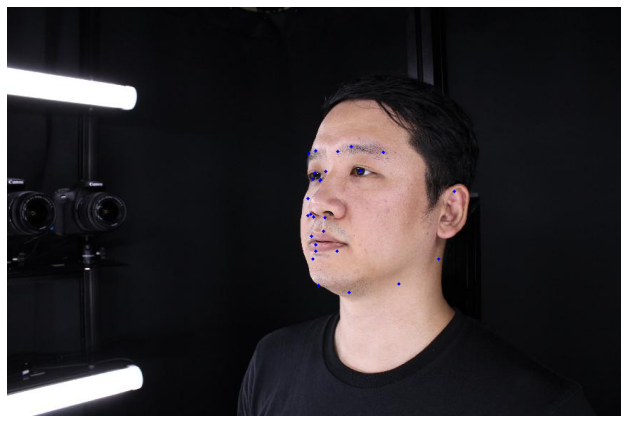

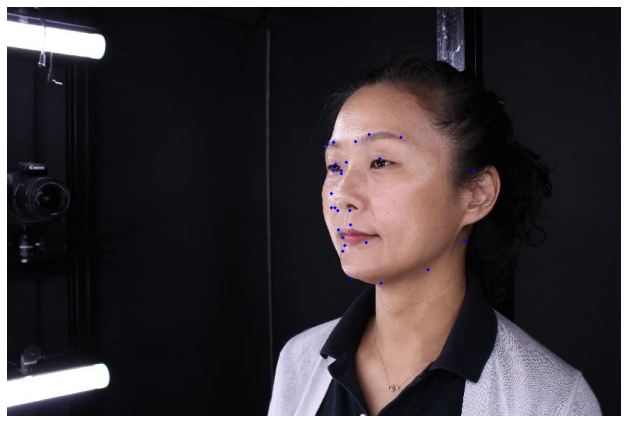

In [28]:
import dlib
from imutils import face_utils, resize

face_detector = dlib.get_frontal_face_detector()

@torch.no_grad()
def inference(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    faces = face_detector(gray, 1)

    outputs = []

    for (i, face) in enumerate(faces):
        (x, y, w, h) = face_utils.rect_to_bb(face)
        # x,y,w,h = 0,0,512,512
        crop_img = gray[y: y + h, x: x + w]
        preprocessed_image = preprocess_image(crop_img)
        # preprocessed_image = preprocess_image(gray)
        landmarks_predictions = model(preprocessed_image)
        outputs.append((landmarks_predictions.cpu(), (x, y, h, w)))

    return draw_landmarks_on_faces(frame, outputs)

from pathlib import Path
start_time = time.time()

model = XceptionNet(num_class=54)
model.eval()
model.load_state_dict(torch.load(
    '/home/ubuntu/workspace/FLD-scratch/src/pretrained_model/xcep_27pt_50epoch.pt',
    map_location = 'cpu'))
model = model

INPUT_ROOT = "/data/komedi/k-face-100"
IMAGE_ROOT = os.path.join(INPUT_ROOT, "rename_image")
IMAGE_LIST = get_file_list(IMAGE_ROOT, case="image")

with torch.no_grad():

    for i in range(2):
        num = random.randint(0,len(IMAGE_LIST)-1)
        img_name = Path(IMAGE_LIST[num]).stem
        image = cv2.imread(IMAGE_LIST[num])
        output = inference(image)

        plt.figure(figsize=(11,11))
        result = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)

        plt.axis("off")
        plt.imshow(result, cmap = 'gray')
        # plt.savefig(f"output/{img_name}.png")

In [33]:
device = 'cpu'
from src.models import fan
from torchsummary import summary
model = fan.FAN().to(device)
summary(model, (3, 128, 128),device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,472
       BatchNorm2d-2           [-1, 64, 64, 64]             128
       BatchNorm2d-3           [-1, 64, 64, 64]             128
            Conv2d-4           [-1, 64, 64, 64]          36,864
       BatchNorm2d-5           [-1, 64, 64, 64]             128
            Conv2d-6           [-1, 32, 64, 64]          18,432
       BatchNorm2d-7           [-1, 32, 64, 64]              64
            Conv2d-8           [-1, 32, 64, 64]           9,216
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]           8,192
        ConvBlock-12          [-1, 128, 64, 64]               0
      BatchNorm2d-13          [-1, 128, 32, 32]             256
           Conv2d-14           [-1, 64,